First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12024721'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '04'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12410074'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12024721'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [ ]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Emina" .',
f':{student_a} foaf:familyName "Skrijelj" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12410074"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Azra" .',
f':{student_b} foaf:familyName "Sisic" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12024721"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [59]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [20]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [22]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The dataset consists of 20,000 samples of handwritten English capital letters,
where each instance represents a scanned image that has been converted 
into 16 numeric features describing shape, stroke patterns, and pixel distributions. 
These features allow the letters to be analyzed without storing the original images.
A scenario for using this data is an automated mail-sorting system in a postal company,
where handwritten characters on envelopes must be recognized quickly and accurately so that
routing and delivery decisions can be made without manual intervention.

"""

business_objectives_comment = """
The main business objective is to support automated mail processing by developing a model 
that can recognize handwritten letters without human involvement. By improving the speed 
and accuracy of character recognition, the company aims to reduce manual sorting costs, decrease 
processing time per mail item, and minimize sorting errors that lead to delays."""

business_success_criteria_comment = """
Business success will be achieved if the final system consistently recognizes 
handwritten letters with high accuracy and operates fast enough for large-scale mail processing. 
A useful threshold for business success is achieving at least around 90% recognition accuracy on 
previously unseen samples, reducing manual sorting effort by a measurable amount, and making sure that 
the automated system does not introduce operational risks like frequent misclassification of 
visually similar letters. The model must be reliable enough to support continuous deployment in a 
logistics workflow.
"""

data_mining_goals_comment = """
The goal is to build a predictive model that can classify each input into one of 26 letter categories
based on the extracted numerical features. This includes selecting a suitable machine learning 
algorithm, performing preprocessing, tuning key hyperparameters, and evaluating 
the model using appropriate metrics for multiclass classification.
"""

data_mining_success_criteria_comment = """
The goal is to have a trained model that reaches strong classification 
performance on a test set, ideally approaching or exceeding 90% accuracy, 
while maintaining balanced performance across all classes. The process should demonstrate 
good improvement through hyperparameter tuning and produce reproducible results documented 
in the provenance graph. Success means that the model meets the technical requirements needed 
to fulfill the business objectives.
"""

ai_risk_aspects_comment = """
Some of the AI risks still exist even though the dataset does not involve personally sensitive attributes.
The system may misclassify visually similar letters,
which could lead to operational errors in automated sorting. The dataset might represent only a
limited range of handwriting styles, making the model less robust when applied to real-world data
that varies in pen type, writing habits, or scanning quality. Also the system must be monitored
for drift and provide fallback options so that uncertain predictions do not automatically trigger
incorrect routing decisions. Transparency about model limitations is important to guarantee safe deployment.
"""


bu_ass_uuid_executor = "5934a559-0cb7-4724-aa5e-4ac7590e1e4d" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [23]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [14]:
# Path to the Letter Recognition dataset
letter_data_path = "data"

# Code writer 
load_letter_data_code_writer = student_a

def load_letter_data() -> pd.DataFrame:
    # Load your data
    input_file = os.path.join(letter_data_path, "letter-recognition.csv")
    raw_data = pd.read_csv(input_file, sep=",", header=0)

    # Basic structuring (analogous to create_date_index, but meaningful here)
    def structure_letter_data(dataframe: pd.DataFrame) -> pd.DataFrame:
        structured_data = dataframe.copy()

        # Ensure target variable is of type string
        structured_data["letter"] = structured_data["letter"].astype(str)

        # Ensure all feature columns are numeric
        feature_cols = structured_data.columns.drop("letter")
        structured_data[feature_cols] = structured_data[feature_cols].apply(
            pd.to_numeric, errors="coerce"
        )

        return structured_data

    loaded_data = structure_letter_data(raw_data)

    return loaded_data


start_time_ld = now()
data = load_letter_data()
end_time_ld = now()

display(data.head())


#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "69b62fdb-3b72-4dfa-b8c5-2efc25e10855"  # Generate once

load_letter_data_executor = [
    f':load_letter_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_letter_data_executor, prefixes=prefixes)


ld_ass_uuid_writer = "5bf9bb27-c76d-4267-bf7c-23618ddc65ce"  # Generate once

ld_report = """
The Letter Recognition dataset was loaded from a CSV file containing 20,000
instances of handwritten English capital letters. Each instance consists of
16 numerical features derived from scanned character images, describing
geometric and pixel-based properties of the characters. The target variable
represents the letter class from A to Z.

"""

load_letter_data_activity = [
    ':load_letter_data rdf:type prov:Activity .',
    ':load_letter_data sc:isPartOf :data_understanding_phase .',
    ':load_letter_data rdfs:comment "Data Understanding" .',
    f':load_letter_data rdfs:comment """{ld_report}""" .',
    f':load_letter_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_letter_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_letter_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_letter_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # INPUT of activity
    ':load_letter_data prov:used :raw_letter_data .',
    ':load_letter_data prov:used :raw_letter_data_path .',
    ':raw_letter_data rdf:type prov:Entity .',
    ':raw_letter_data_path rdf:type prov:Entity .',
    ':raw_letter_data prov:wasDerivedFrom :raw_letter_data_path .',

    # OUTPUT of activity
    ':letter_data rdf:type prov:Entity .',
    ':letter_data prov:wasGeneratedBy :load_letter_data .',
    ':letter_data prov:wasDerivedFrom :raw_letter_data .',
]
engine.insert(load_letter_data_activity, prefixes=prefixes)

# Further describe the raw data using Croissant
raw_data_triples = [
    ':raw_letter_data rdf:type sc:Dataset .',
    ':raw_letter_data sc:name "Letter Recognition Dataset" .',
    ':raw_letter_data sc:description "Dataset of handwritten English capital letters represented by 16 numerical, dimensionless image-derived features." .',

    # CSV file
    ':letter_csv rdf:type cr:FileObject .',
    ':letter_csv sc:name "letter-recognition.csv" .',
    ':letter_csv sc:encodingFormat "text/csv" .',
    ':raw_letter_data sc:distribution :letter_csv .',

    # RecordSet
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name "Handwritten letter samples" .',
    ':raw_recordset cr:source :letter_csv .',
    ':raw_letter_data cr:recordSet :raw_recordset .',

    # Target field
    ':raw_recordset cr:field :field_letter .',
    ':field_letter rdf:type cr:Field .',
    ':field_letter sc:name "letter" .',
    ':field_letter sc:description "Target label representing the handwritten capital letter (A–Z)." .',
    ':field_letter cr:dataType xsd:string .',

    #  numeric features
    ':raw_recordset cr:field :field_x_box .',
    ':field_x_box rdf:type cr:Field .',
    ':field_x_box sc:name "xbox" .',
    ':field_x_box sc:description "Horizontal position of the bounding box of the character." .',
    ':field_x_box cr:dataType xsd:integer .',

    ':raw_recordset cr:field :field_y_box .',
    ':field_y_box rdf:type cr:Field .',
    ':field_y_box sc:name "ybox" .',
    ':field_y_box sc:description "Vertical position of the bounding box of the character." .',
    ':field_y_box cr:dataType xsd:integer .',

    ':raw_recordset cr:field :field_width .',
    ':field_width rdf:type cr:Field .',
    ':field_width sc:name "width" .',
    ':field_width sc:description "Width of the character bounding box." .',
    ':field_width cr:dataType xsd:integer .',
]
engine.insert(raw_data_triples, prefixes=prefixes)


# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':letter_data rdf:type sc:Dataset .',
    ':letter_data sc:name "Loaded Letter Recognition Dataset" .',
    ':letter_data sc:description "In-memory dataset obtained by loading the letter recognition CSV file into a pandas DataFrame." .',

    ':letter_recordset rdf:type cr:RecordSet .',
    ':letter_data cr:recordSet :letter_recordset .',

    # Reuse schema from raw dataset
    ':letter_recordset cr:field :field_letter .',
    ':letter_recordset cr:field :field_x_box .',
    ':letter_recordset cr:field :field_y_box .',
    ':letter_recordset cr:field :field_width .',
]
engine.insert(data_triples, prefixes=prefixes)


# Add units to the fields based on dataset context
units_triples = [
    ':field_x_box qudt:unit qudt:Unitless .',
    ':field_y_box qudt:unit qudt:Unitless .',
    ':field_width qudt:unit qudt:Unitless .',
]
engine.insert(units_triples, prefixes=prefixes)


,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


KeyboardInterrupt: 

In [28]:
check_outliers_code_writer = student_a

def check_outliers(
    data: pd.DataFrame,
    threshold: float = 2.2,
    exclude_columns: tuple = ('letter',)
) -> dict:
    """
    Identify potential outliers in numeric feature columns using z-scores.
    This is a simple, exploratory method used for data understanding purposes.
    """

    results = {}

    # Work on a clean copy
    tmp = data.copy().reset_index(drop=True)

    # Select numeric columns only, excluding target variable
    numeric_columns = [
        col for col in tmp.columns
        if col not in exclude_columns and pd.api.types.is_numeric_dtype(tmp[col])
    ]

    for col in numeric_columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        # Skip columns with no variance
        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std
        mask = np.abs(z_scores) > threshold

        outlier_indices = values[mask].index

        outlier_info = [
            {
                "index": int(idx),
                "z_score": float(z_scores.loc[idx])
            }
            for idx in outlier_indices
        ]

        results[col] = outlier_info

    return results


# Execute outlier detection
start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)
end_time_co = now()

# Inspect report
start_time_ho = now()
print(outliers_report)
end_time_ho = now()


#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

#############################################
# Documentation
#############################################

# 1. Activity: Checking for outliers and creating the report

co_ass_uuid_executor = "766a9b36-9d40-4c25-8dc5-8f20c30b138c"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "2203ce09-def8-40fb-a80d-469fbe069728"

co_comment = """
Potential outliers were identified using a simple z-score-based approach applied
to all numeric feature columns. Values with an absolute z-score greater than 2.2
were flagged as outliers. This threshold is intentionally chosen for demonstration
purposes and exploratory data understanding, rather than as a statistically strict
criterion.
"""

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment "Data Understanding" .',
    f':check_outliers rdfs:comment """{co_comment}""" .',
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :letter_data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)


# 2. Activity: Inspecting the outlier report and taking a decision

ior_ass_uuid_executor = "9eef97ad-e445-454d-9034-2da1cc99aa54"

ior_comment = """
After inspecting the outlier report, the identified extreme values are considered
in the context of handwritten character data. No immediate removal is performed
at this stage, as such values may represent valid but rare writing styles.
A final decision on handling outliers will be taken during the data preparation phase.
"""

inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:comment "Data Understanding" .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_ho}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{student_a} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment "Outliers are documented but not removed at this stage." .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)


{'xbox ': [{'index': 9, 'z_score': 3.6464603288414508}, {'index': 27, 'z_score': 4.169141682372466}, {'index': 255, 'z_score': 2.60109762177942}, {'index': 354, 'z_score': 3.6464603288414508}, {'index': 384, 'z_score': 3.1237789753104357}, {'index': 402, 'z_score': 3.6464603288414508}, {'index': 423, 'z_score': 2.60109762177942}, {'index': 459, 'z_score': 2.60109762177942}, {'index': 497, 'z_score': 2.60109762177942}, {'index': 511, 'z_score': 2.60109762177942}, {'index': 539, 'z_score': 2.60109762177942}, {'index': 552, 'z_score': 4.691823035903481}, {'index': 569, 'z_score': 2.60109762177942}, {'index': 640, 'z_score': 2.60109762177942}, {'index': 654, 'z_score': 3.1237789753104357}, {'index': 738, 'z_score': 2.60109762177942}, {'index': 766, 'z_score': 2.60109762177942}, {'index': 779, 'z_score': 2.60109762177942}, {'index': 783, 'z_score': 3.1237789753104357}, {'index': 823, 'z_score': 2.60109762177942}, {'index': 844, 'z_score': 2.60109762177942}, {'index': 848, 'z_score': 2.60109

**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

In [7]:
skew_code_writer = student_a

def calculate_distribution_properties(data: pd.DataFrame) -> dict:
    """
    Calculates skewness for all numerical feature columns
    in the Letter Recognition dataset.
    """

    # All numeric feature columns (exclude target)
    numeric_features = data.drop(columns=["letter"]).columns.tolist()

    skewness_series = data[numeric_features].skew()
    skewness_report = skewness_series.to_dict()

    return skewness_report


# Execution and Timing
start_time_skew = now()
skew_report = calculate_distribution_properties(data)
end_time_skew = now()

# Display results for inspection
print("Calculated Skewness (sorted):")
print(pd.Series(skew_report).sort_values(ascending=False))


#############################################
# Documentation
#############################################

dist_comment = f"""
Skewness was computed for all numerical feature attributes of the
Letter Recognition dataset.

The features represent engineered, image-derived descriptors such as
bounding box geometry, pixel distributions, and edge-related measures.
Several features exhibit mild positive or negative skewness, which is
expected due to the bounded and discrete nature of the underlying values
(e.g., integer ranges from 0 to 15).

No extreme skewness values were observed that would indicate data quality
issues. The observed skewness patterns are typical for handcrafted feature
representations derived from scanned character images.

Calculated skewness values:
{json.dumps(skew_report, indent=2)}
"""

skew_ass_uuid_executor = "12872787-8968-4e16-8019-2671930279d2" 
skew_ass_uuid_writer = "f80da834-a4c7-4595-8b96-b40c73eb6250"    

skew_activity = [
    ':calculate_skewness rdf:type prov:Activity .',
    ':calculate_skewness sc:isPartOf :data_understanding_phase .',
    ':calculate_skewness rdfs:comment "Distribution and Skewness Check" .',
    f':calculate_skewness rdfs:comment """{dist_comment}""" .',
    f':calculate_skewness prov:startedAtTime "{start_time_skew}"^^xsd:dateTime .',
    f':calculate_skewness prov:endedAtTime "{end_time_skew}"^^xsd:dateTime .',

    # Executor
    f':calculate_skewness prov:qualifiedAssociation :{skew_ass_uuid_executor} .',
    f':{skew_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{skew_ass_uuid_executor} rdf:type prov:Association .',
    f':{skew_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':calculate_skewness prov:qualifiedAssociation :{skew_ass_uuid_writer} .',
    f':{skew_ass_uuid_writer} prov:agent :{skew_code_writer} .',
    f':{skew_ass_uuid_writer} rdf:type prov:Association .',
    f':{skew_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':calculate_skewness prov:used :letter_data .',
    ':skewness_report rdf:type prov:Entity .',
    f':skewness_report rdfs:comment """{json.dumps(skew_report, indent=2)}""" .',
    ':skewness_report prov:wasGeneratedBy :calculate_skewness .',
]

engine.insert(skew_activity, prefixes=prefixes)


NameError: name 'pd' is not defined

In [29]:
check_missing_values_code_writer = student_a
missing_counts = data.isna().sum()

print("Missing values per column:")
print(missing_counts)

#############################################
# Documentation
#############################################
# Activity: Checking for missing values
#############################################


# 1. Activity: Checking missing values and creating the report

mv_ass_uuid_executor = "698b0866-5d7e-4730-835e-75d87b32aff4"  # generated once

check_missing_values_executor = [
    f':check_missing_values prov:qualifiedAssociation :{mv_ass_uuid_executor} .',
    f':{mv_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mv_ass_uuid_executor} rdf:type prov:Association .',
    f':{mv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_missing_values_executor, prefixes=prefixes)


mv_ass_uuid_writer = "59c6dd95-7712-47e8-92b3-92afaf4941b6"  # generated once

mv_comment = """
Checking the dataset for missing values by counting null entries per column.
The resulting report summarizes the number of missing values for each feature.
"""

check_missing_values_activity = [
    ':check_missing_values rdf:type prov:Activity .',
    ':check_missing_values sc:isPartOf :data_understanding_phase .',
    ':check_missing_values rdfs:comment "Data Understanding" .',
    f':check_missing_values rdfs:comment """{mv_comment}""" .',
    f':check_missing_values prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':check_missing_values prov:endedAtTime "{end_time_ho}"^^xsd:dateTime .',
    f':check_missing_values prov:qualifiedAssociation :{mv_ass_uuid_writer} .',
    f':{mv_ass_uuid_writer} prov:agent :{check_missing_values_code_writer} .',
    f':{mv_ass_uuid_writer} rdf:type prov:Association .',
    f':{mv_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input
    ':check_missing_values prov:used :letter_data .',

    # Output
    ':missing_values_report rdf:type prov:Entity .',
    f':missing_values_report rdfs:comment """{missing_counts.to_dict()}""" .',
    ':missing_values_report prov:wasGeneratedBy :check_missing_values .',
]
engine.insert(check_missing_values_activity, prefixes=prefixes)

# Step 2: No missing values are present, no action required

imv_ass_uuid_executor = "d0a3f8a7-8d0c-4f5e-b51b-9f1b6a3a9d52"  # generate once

imv_comment = """
The missing values report was inspected. No missing values were detected in any
of the dataset columns. Therefore, no data cleaning or imputation is required
at this stage.
"""

inspect_missing_values_executor = student_a

inspect_missing_values_activity = [
    ':inspect_missing_values rdf:type prov:Activity .',
    ':inspect_missing_values rdfs:comment "Data Understanding" .',
    f':inspect_missing_values rdfs:comment """{imv_comment}""" .',
    f':inspect_missing_values prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':inspect_missing_values prov:endedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':inspect_missing_values prov:qualifiedAssociation :{imv_ass_uuid_executor} .',
    f':{imv_ass_uuid_executor} prov:agent :{inspect_missing_values_executor} .',
    f':{imv_ass_uuid_executor} rdf:type prov:Association .',
    f':{imv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Input
    ':inspect_missing_values prov:used :missing_values_report .',

    # Decision
    ':missing_values_decision rdf:type prov:Entity .',
    f':missing_values_decision rdfs:comment """No action required, dataset is complete.""" .',
    ':missing_values_decision prov:wasGeneratedBy :inspect_missing_values .',
]
engine.insert(inspect_missing_values_activity, prefixes=prefixes)


# Step 3: Since no missing values were found, no data modification is performed


Missing values per column:
letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64


        min  max     mean       std
xbox      0   15  4.02355  1.913212
ybox      0   15  7.03550  3.304555
width     0   15  5.12185  2.014573
height    0   15  5.37245  2.261390
onpix     0   15  3.50585  2.190458
xbar      0   15  6.89760  2.026035
ybar      0   15  7.50045  2.325354
x2bar     0   15  4.62860  2.699968
y2bar     0   15  5.17865  2.380823
xybar     0   15  8.28205  2.488475
x2ybar    0   15  6.45400  2.631070
xy2bar    0   15  7.92900  2.080619
xedge     0   15  3.04610  2.332541
xedgey    0   15  8.33885  1.546722
yedge     0   15  3.69175  2.567073
yedgex    0   15  7.80120  1.617470


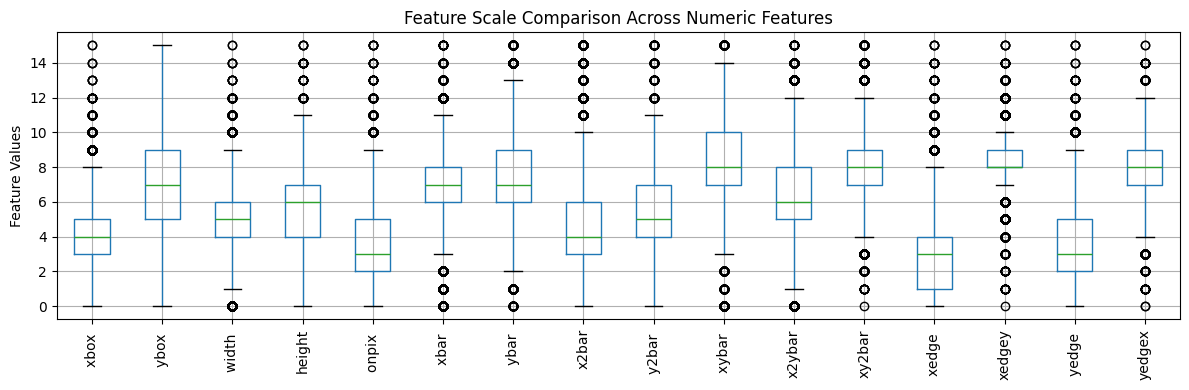

In [ ]:
check_feature_scales_code_writer = student_a

numeric_features = data.drop(columns=["letter"])

scale_summary = pd.DataFrame({
    "min": numeric_features.min(),
    "max": numeric_features.max(),
    "mean": numeric_features.mean(),
    "std": numeric_features.std()
})

print(scale_summary)

# Boxplots for Feature Scale Comparison

plt.figure(figsize=(12, 4))
numeric_features.boxplot()
plt.xticks(rotation=90)
plt.title("Feature Scale Comparison Across Numeric Features")
plt.ylabel("Feature Values")
plt.tight_layout()
plt.show()

#############################################
# Documentation
#############################################
# Feature Scale Differences
#############################################
# 1. Activity: Checking feature scales and creating the report

fs_ass_uuid_executor = "90096c03-d129-4b1f-8663-e988f1a544d5"
check_feature_scales_executor = [
    f':check_feature_scales prov:qualifiedAssociation :{fs_ass_uuid_executor} .',
    f':{fs_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{fs_ass_uuid_executor} rdf:type prov:Association .',
    f':{fs_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_feature_scales_executor, prefixes=prefixes)


fs_ass_uuid_writer = "4f12dc98-134a-4d4d-9bfe-d6232aed5b13"
fs_comment = """
Identifying differences in feature scales by computing minimum, maximum, mean,
and standard deviation values for each numeric feature. The observed minimum and
maximum values fall within the expected bounded range of the dataset, indicating
that the feature values are plausible and no invalid measurements are present.
"""

check_feature_scales_activity = [
    ':check_feature_scales rdf:type prov:Activity .',
    ':check_feature_scales sc:isPartOf :data_understanding_phase .',
    ':check_feature_scales rdfs:comment \'Data Understanding\' .',
    f':check_feature_scales rdfs:comment """{fs_comment}""" .',
    f':check_feature_scales prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':check_feature_scales prov:endedAtTime "{end_time_ho}"^^xsd:dateTime .',
    f':check_feature_scales prov:qualifiedAssociation :{fs_ass_uuid_writer} .',
    f':{fs_ass_uuid_writer} prov:agent :{check_feature_scales_code_writer} .',
    f':{fs_ass_uuid_writer} rdf:type prov:Association .',
    f':{fs_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input
    ':check_feature_scales prov:used :letter_data .',

    # Output
    ':feature_scale_report rdf:type prov:Entity .',
    f':feature_scale_report rdfs:comment """{scale_summary.to_dict()}""" .',
    ':feature_scale_report prov:wasGeneratedBy :check_feature_scales .',
]
engine.insert(check_feature_scales_activity, prefixes=prefixes)


# 2. Activity: Inspecting the report and taking a decision on what to do

ifs_ass_uuid_executor = "688155e7-21b3-48d6-904f-58bf832e48bc"
ifs_comment = """
After inspecting the feature scale report, it was observed that although all
numeric features share the same bounded range, their standard deviations differ
substantially. To prevent features with larger variance from dominating the
learning process, the decision was made to apply feature scaling during the
Data Preparation phase.
"""

inspect_feature_scales_executor = student_a

inspect_feature_scales_activity = [
    ':inspect_feature_scales rdf:type prov:Activity .',
    ':inspect_feature_scales rdfs:comment \'Data Understanding\' .',
    f':inspect_feature_scales rdfs:comment """{ifs_comment}""" .',
    f':inspect_feature_scales prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':inspect_feature_scales prov:endedAtTime "{end_time_ho}"^^xsd:dateTime .',
    f':inspect_feature_scales prov:qualifiedAssociation :{ifs_ass_uuid_executor} .',
    f':{ifs_ass_uuid_executor} prov:agent :{inspect_feature_scales_executor} .',
    f':{ifs_ass_uuid_executor} rdf:type prov:Association .',
    f':{ifs_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Input
    ':inspect_feature_scales prov:used :feature_scale_report .',

    # Decision
    ':feature_scale_decision rdf:type prov:Entity .',
    f':feature_scale_decision rdfs:comment """Apply feature scaling during Data Preparation.""" .',
    ':feature_scale_decision prov:wasGeneratedBy :inspect_feature_scales .',
]
engine.insert(inspect_feature_scales_activity, prefixes=prefixes)


In [ ]:
vis_code_writer = student_a

def visualizations(data: pd.DataFrame):

    #  Class distribution of target variable
    fig1, ax1 = plt.subplots(figsize=(8, 5))

    data['letter'].value_counts().sort_index().plot(
        kind='bar',
        ax=ax1,
        edgecolor='black'
    )

    ax1.set_title('Distribution of Letter Classes (A–Z)')
    ax1.set_xlabel('Letter')
    ax1.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_letter_distribution.png')
    plt.close(fig1)

    # Distribution of a representative feature
    fig2, ax2 = plt.subplots(figsize=(7, 5))

    ax2.hist(data['xbox'], bins=10, edgecolor='black')
    ax2.set_title('Distribution of Feature: xbox')
    ax2.set_xlabel('xbox value')
    ax2.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_xbox_distribution.png')
    plt.close(fig2)

    letter_distribution = data['letter'].value_counts().to_dict()
    xbox_summary = data['xbox'].describe().to_dict()

    return {
        'figures_generated': 2,
        'description': 'Bar chart of letter class distribution and histogram of xbox feature.',
        'letter_class_distribution': letter_distribution,
        'xbox_summary_statistics': xbox_summary
    }


# Execution and Timing
start_time_vis = now()
vis_report = visualizations(data)
end_time_vis = now()

vis_ass_uuid_executor = "e4d1f63b-0a51-45d7-9f5b-7d5c4a1a9e0f"
vis_ass_uuid_writer   = "2c7f96a4-45a9-4a45-8e34-82d5e3fd3f27"

vis_comment = f"""
Visual exploration of the Letter Recognition dataset shows that the target
variable (letter classes A–Z) is approximately evenly distributed, indicating
no severe class imbalance or underrepresented categories.

The histogram of the representative numeric feature 'xbox' shows a bounded
distribution with values concentrated within the expected range, confirming
plausibility of the image-derived measurements and absence of extreme values.

These visualizations support the suitability of the dataset for multi-class
classification and motivate the application of feature scaling in the data
preparation phase.

Visual summary:
{json.dumps(vis_report, indent=2)}
"""

vis_activity = [
    ':visualize_data_properties rdf:type prov:Activity .',
    ':visualize_data_properties sc:isPartOf :data_understanding_phase .',
    ':visualize_data_properties rdfs:comment "Visual Exploration and Hypothesis Generation" .',
    f':visualize_data_properties rdfs:comment """{vis_comment}""" .',
    f':visualize_data_properties prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visualize_data_properties prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',

    # Executor
    f':visualize_data_properties prov:qualifiedAssociation :{vis_ass_uuid_executor} .',
    f':{vis_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_ass_uuid_executor} rdf:type prov:Association .',
    f':{vis_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':visualize_data_properties prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{vis_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':visualize_data_properties prov:used :letter_data .',
    ':visual_analysis_report rdf:type prov:Entity .',
    f':visual_analysis_report rdfs:label "2D Visual Exploration of Letter Data" .',
    f':visual_analysis_report rdfs:comment """{json.dumps(vis_report, indent=2)}""" .',
    ':visual_analysis_report prov:wasGeneratedBy :visualize_data_properties .',
]

engine.insert(vis_activity, prefixes=prefixes)



In [ ]:
def visualizations(data: pd.DataFrame):

    #  Class distribution of target variable
    fig1, ax1 = plt.subplots(figsize=(8, 5))

    data['letter'].value_counts().sort_index().plot(
        kind='bar',
        ax=ax1,
        edgecolor='black'
    )

    ax1.set_title('Distribution of Letter Classes (A–Z)')
    ax1.set_xlabel('Letter')
    ax1.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_letter_distribution.png')
    plt.close(fig1)

    # Distribution of a representative feature
    fig2, ax2 = plt.subplots(figsize=(7, 5))

    ax2.hist(data['xbox '], bins=10, edgecolor='black')
    ax2.set_title('Distribution of Feature: xbox')
    ax2.set_xlabel('xbox value')
    ax2.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_xbox_distribution.png')
    plt.close(fig2)

    letter_distribution = data['letter'].value_counts().to_dict()
    xbox_summary = data['xbox '].describe().to_dict()

    return {
        'figures_generated': 2,
        'description': 'Bar chart of letter class distribution and histogram of xbox feature.',
        'letter_class_distribution': letter_distribution,
        'xbox_summary_statistics': xbox_summary
    }


# Execution and Timing
start_time_vis = now()
vis_report = visualizations(data)
end_time_vis = now()


vis_ass_uuid_executor = "e4d1f63b-0a51-45d7-9f5b-7d5c4a1a9e0f"
vis_ass_uuid_writer   = "2c7f96a4-45a9-4a45-8e34-82d5e3fd3f27"

vis_comment = f"""
Firstly we visually explored the target variable of the dataset. It is approximately evenly distributed, indicating
no severe class imbalance or underrepresented categories.

The histogram of the representative numeric feature 'xbox' shows a bounded
distribution with values concentrated within the expected range, confirming
plausibility of the image-derived measurements and absence of extreme values.

These visualizations support the suitability of the dataset for multi-class
classification and motivate our idea of the of feature scaling in the data
preparation phase.

Visual summary:
{json.dumps(vis_report, indent=2)}
"""

vis_activity = [
    ':visualize_data_properties rdf:type prov:Activity .',
    ':visualize_data_properties sc:isPartOf :data_understanding_phase .',
    ':visualize_data_properties rdfs:comment "Visual Exploration and Hypothesis Generation" .',
    f':visualize_data_properties rdfs:comment """{vis_comment}""" .',
    f':visualize_data_properties prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visualize_data_properties prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',

    # Executor
    f':visualize_data_properties prov:qualifiedAssociation :{vis_ass_uuid_executor} .',
    f':{vis_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_ass_uuid_executor} rdf:type prov:Association .',
    f':{vis_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':visualize_data_properties prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{vis_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':visualize_data_properties prov:used :letter_data .',
    ':visual_analysis_report rdf:type prov:Entity .',
    f':visual_analysis_report rdfs:label "2D Visual Exploration of Letter Data" .',
    f':visual_analysis_report rdfs:comment """{json.dumps(vis_report, indent=2)}""" .',
    ':visual_analysis_report prov:wasGeneratedBy :visualize_data_properties .',
]

engine.insert(vis_activity, prefixes=prefixes)


In [ ]:
# 2. e

bias_report_comment = """
Ethical Sensitivity:
The Letter Recognition dataset does not contain any personal, demographic, or
otherwise ethically sensitive attributes. All instances represent scanned
handwritten characters without any linkage to identifiable individuals.
Therefore, the dataset poses minimal ethical risk with respect to privacy,
discrimination, or unfair treatment of individuals.

Minority Classes and Class Balance:
The target variable consists of 26 capital letters (A–Z). Visual inspection of
the class distribution indicates that the letter classes are approximately
evenly represented, and no severe class imbalance or underrepresented categories
were identified. As a result, no specific over-sampling or under-sampling
strategies are required.

Potential Bias Considerations:
Although no explicit sensitive attributes are present, implicit bias may still
arise from the limited diversity of handwriting styles captured in the dataset.
For example, the dataset may underrepresent certain writing habits, pen types,
or writing conditions. This could affect generalization performance when the
model is applied to handwriting data collected under different conditions.

Evaluation Implications:
Model evaluation should focus on balanced multi-class metrics (e.g., macro-averaged
accuracy or F1-score) to ensure consistent performance across all letter classes.
"""

ass_uuid_executor_2e = "574897f0-5536-4b58-9869-fa7ab07740d7"
ass_uuid_writer_2e = "56c6996f-62b0-4a8f-b280-0dc2b28bd553"

start_time_2e = now()
end_time_2e = now()

log_bias_activity = [
    ':log_bias_evaluation rdf:type prov:Activity .',
    ':log_bias_evaluation sc:isPartOf :data_understanding_phase .',
    f':log_bias_evaluation rdfs:comment "Bias and Ethical Sensitivity Evaluation" .',

    # Time
    f':log_bias_evaluation prov:startedAtTime "{start_time_2e}"^^xsd:dateTime .',
    f':log_bias_evaluation prov:endedAtTime "{end_time_2e}"^^xsd:dateTime .',

    # Executor
    f':log_bias_evaluation prov:qualifiedAssociation :{ass_uuid_executor_2e} .',
    f':{ass_uuid_executor_2e} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_2e} rdf:type prov:Association .',
    f':{ass_uuid_executor_2e} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_bias_evaluation prov:qualifiedAssociation :{ass_uuid_writer_2e} .',
    f':{ass_uuid_writer_2e} prov:agent :{student_a} .',
    f':{ass_uuid_writer_2e} rdf:type prov:Association .',
    f':{ass_uuid_writer_2e} prov:hadRole :{code_writer_role} .',

    # Entity
    ':du_bias_evaluation rdf:type prov:Entity .',
    ':du_bias_evaluation prov:wasGeneratedBy :log_bias_evaluation .',
    ':du_bias_evaluation rdfs:label "2e Bias and Ethical Sensitivity Evaluation" .',
    f':du_bias_evaluation rdfs:comment """{bias_report_comment}""" .',
]

engine.insert(log_bias_activity, prefixes=prefixes)


In [ ]:
# 2f

risk_report_comment = """
Potential Risks and Additional Biases:
Although the Letter Recognition dataset does not contain ethically sensitive or
personal attributes, there do exist potential sources of bias and data quality risks. 
The dataset may not capture the full diversity of real-world handwriting
styles, since it is unclear how many writers contributed to the data or whether
variations in age, cultural background, writing habits, or motor skills are
adequately represented.

Secondly, the dataset only contains English capital  letters written using the Latin alphabet, which is quite limiting. 
A model trained on this data could perform poorly on lowercase letters, non-Latin text etc.

Another potential risk lies in the feature extraction process. Since the dataset
contains precomputed numeric features rather than raw images, any bias or loss
of information introduced during feature extraction is inherited by downstream
models and cannot be corrected at later stages.

Questions for External Experts:
To better assess potential bias and data quality issues, the following questions
would need to be clarified by dataset curators or domain experts:
- How many distinct writers contributed to the dataset?
- Under what conditions were the handwritten characters collected and scanned?
- Are certain handwriting styles or character shapes overrepresented?
- What preprocessing or normalization steps were applied during feature extraction?
- Is the dataset considered representative of modern, real-world handwriting use cases?
"""

ass_uuid_executor_2f = "6c5f291a-871c-4e8e-8757-fe31455cc0e4"
ass_uuid_writer_2f   = "61027c8b-a216-47b4-bc91-1d8d5de2ea2f"

start_time_2f = now()
end_time_2f = now()

log_risk_activity = [
    ':log_risk_evaluation rdf:type prov:Activity .',
    ':log_risk_evaluation sc:isPartOf :data_understanding_phase .',
    f':log_risk_evaluation rdfs:comment "Risk and Bias Assessment" .',

    # Time
    f':log_risk_evaluation prov:startedAtTime "{start_time_2f}"^^xsd:dateTime .',
    f':log_risk_evaluation prov:endedAtTime "{end_time_2f}"^^xsd:dateTime .',

    # Executor
    f':log_risk_evaluation prov:qualifiedAssociation :{ass_uuid_executor_2f} .',
    f':{ass_uuid_executor_2f} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_2f} rdf:type prov:Association .',
    f':{ass_uuid_executor_2f} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_risk_evaluation prov:qualifiedAssociation :{ass_uuid_writer_2f} .',
    f':{ass_uuid_writer_2f} prov:agent :{student_a} .',
    f':{ass_uuid_writer_2f} rdf:type prov:Association .',
    f':{ass_uuid_writer_2f} prov:hadRole :{code_writer_role} .',

    # Entity
    ':du_risk_evaluation rdf:type prov:Entity .',
    ':du_risk_evaluation prov:wasGeneratedBy :log_risk_evaluation .',
    ':du_risk_evaluation rdfs:label "2f Risk and Bias Assessment" .',
    f':du_risk_evaluation rdfs:comment """{risk_report_comment}""" .',
]

engine.insert(log_risk_activity, prefixes=prefixes)


## Data Preparation

In [65]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [ ]:
# Part 3b – Preprocessing Steps Considered but Not Applied


prep_not_applied_comment = """
There are several  steps that are usually part of preprocessing but we decided against using them. The argumentation for them is:

1. Outlier removal - considering that our dataset did not have any outliers we did not have the need for performing any steps that 
are related to outlier handling.

2. Missing value imputation - we have also explored if our dataset had any missing values, and since it did not have any,
there was no need to take any steps regarding handling missing values.

3. Feature removal was something that we did consider and discuss, but all 16 numeric attributes represent distinct geometric or
   pixel-based properties and they seem to all be informative and important for the classification task.

4. Binning or discretization of numeric features was not applied. The features are already
   discrete and bounded, so there was no need for these steps.

5. Alternative scaling methods such as min–max scaling were considered. Standardization
   (zero mean, unit variance) was selected instead, as it is more suitable for models sensitive
   to feature variance.
"""

ass_uuid_executor_3b = "5722057f-7e98-49d8-9d77-0f92c06fa415"
ass_uuid_writer_3b   = "56fbfe25-23a7-4f17-a3b5-7bfa21f30e66"

start_time_3b = now()
end_time_3b   = now()

log_prep_not_applied_activity = [
    ':log_prep_not_applied rdf:type prov:Activity .',
    ':log_prep_not_applied sc:isPartOf :data_preparation_phase .',
    f':log_prep_not_applied rdfs:comment "3b Preprocessing Steps Considered but Not Applied" .',

    f':log_prep_not_applied prov:startedAtTime "{start_time_3b}"^^xsd:dateTime .',
    f':log_prep_not_applied prov:endedAtTime "{end_time_3b}"^^xsd:dateTime .',

    # Executor
    f':log_prep_not_applied prov:qualifiedAssociation :{ass_uuid_executor_3b} .',
    f':{ass_uuid_executor_3b} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_3b} rdf:type prov:Association .',
    f':{ass_uuid_executor_3b} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_prep_not_applied prov:qualifiedAssociation :{ass_uuid_writer_3b} .',
    f':{ass_uuid_writer_3b} prov:agent :{student_b} .',
    f':{ass_uuid_writer_3b} rdf:type prov:Association .',
    f':{ass_uuid_writer_3b} prov:hadRole :{code_writer_role} .',

    # Entity
    ':dp_preprocessing_not_applied rdf:type prov:Entity .',
    ':dp_preprocessing_not_applied prov:wasGeneratedBy :log_prep_not_applied .',
    ':dp_preprocessing_not_applied rdfs:label "3b Preprocessing Steps Considered but Not Applied" .',
    f':dp_preprocessing_not_applied rdfs:comment """{prep_not_applied_comment}""" .',
]

engine.insert(log_prep_not_applied_activity, prefixes=prefixes)


In [ ]:
# Part 3c – Derived Attributes Analysis

derived_attributes_comment = """
The potential for derived attributes was evaluated for the Letter Recognition dataset.

Possible derived attributes that we have considered include:
1. Ratios or combinations of existing geometric features (e.g., width-to-height ratio,
   edge density ratios).
2. Polynomial feature expansions to capture non-linear interactions between attributes.
3. Aggregate measures combining multiple edge or pixel-related features.

None of these options we are done because:
- The existing attributes are already compact, low-dimensional, and semantically meaningful.
- Additional derived features could introduce redundancy and multicollinearity.
- The primary modeling goal is evaluating classification performance using the
  original standardized feature representation.


"""

ass_uuid_executor_3c = "dc7585a2-5677-4e9b-923c-73db54405a0c"
ass_uuid_writer_3c   = "c7280aeb-5549-4a6b-beb6-7ddab8ea5f76"

start_time_3c = now()
end_time_3c   = now()

log_derived_attributes_activity = [
    ':log_derived_attributes rdf:type prov:Activity .',
    ':log_derived_attributes sc:isPartOf :data_preparation_phase .',
    f':log_derived_attributes rdfs:comment "3c Derived Attributes Analysis" .',

    f':log_derived_attributes prov:startedAtTime "{start_time_3c}"^^xsd:dateTime .',
    f':log_derived_attributes prov:endedAtTime "{end_time_3c}"^^xsd:dateTime .',

    # Executor
    f':log_derived_attributes prov:qualifiedAssociation :{ass_uuid_executor_3c} .',
    f':{ass_uuid_executor_3c} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_3c} rdf:type prov:Association .',
    f':{ass_uuid_executor_3c} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_derived_attributes prov:qualifiedAssociation :{ass_uuid_writer_3c} .',
    f':{ass_uuid_writer_3c} prov:agent :{student_b} .',
    f':{ass_uuid_writer_3c} rdf:type prov:Association .',
    f':{ass_uuid_writer_3c} prov:hadRole :{code_writer_role} .',

    # Entity
    ':dp_derived_attributes_analysis rdf:type prov:Entity .',
    ':dp_derived_attributes_analysis prov:wasGeneratedBy :log_derived_attributes .',
    ':dp_derived_attributes_analysis rdfs:label "3c Derived Attributes Analysis" .',
    f':dp_derived_attributes_analysis rdfs:comment """{derived_attributes_comment}""" .',
]

engine.insert(log_derived_attributes_activity, prefixes=prefixes)


In [67]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [68]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [69]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [70]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [71]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [72]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [73]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [74]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [75]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [76]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [77]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [78]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [79]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [80]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [81]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [82]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
